# 강아지 비만여부 파악

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as T

import timm
from sklearn.metrics import accuracy_score

/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /opt/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# Custom Dataset

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i in range(2):
            img_list = os.listdir(os.path.join(root_path, str(i)))
            for img in img_list:
                if img != '.DS_Store':
                    img_path = os.path.join(os.path.join(root_path, str(i)), img)
                    self.data.append((img_path, i))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [4]:
transforms = T.Compose([
    T.Resize((112, 112)),
    T.RandomHorizontalFlip(0.5),
    T.ToTensor()
])

total_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/16/data', transforms)

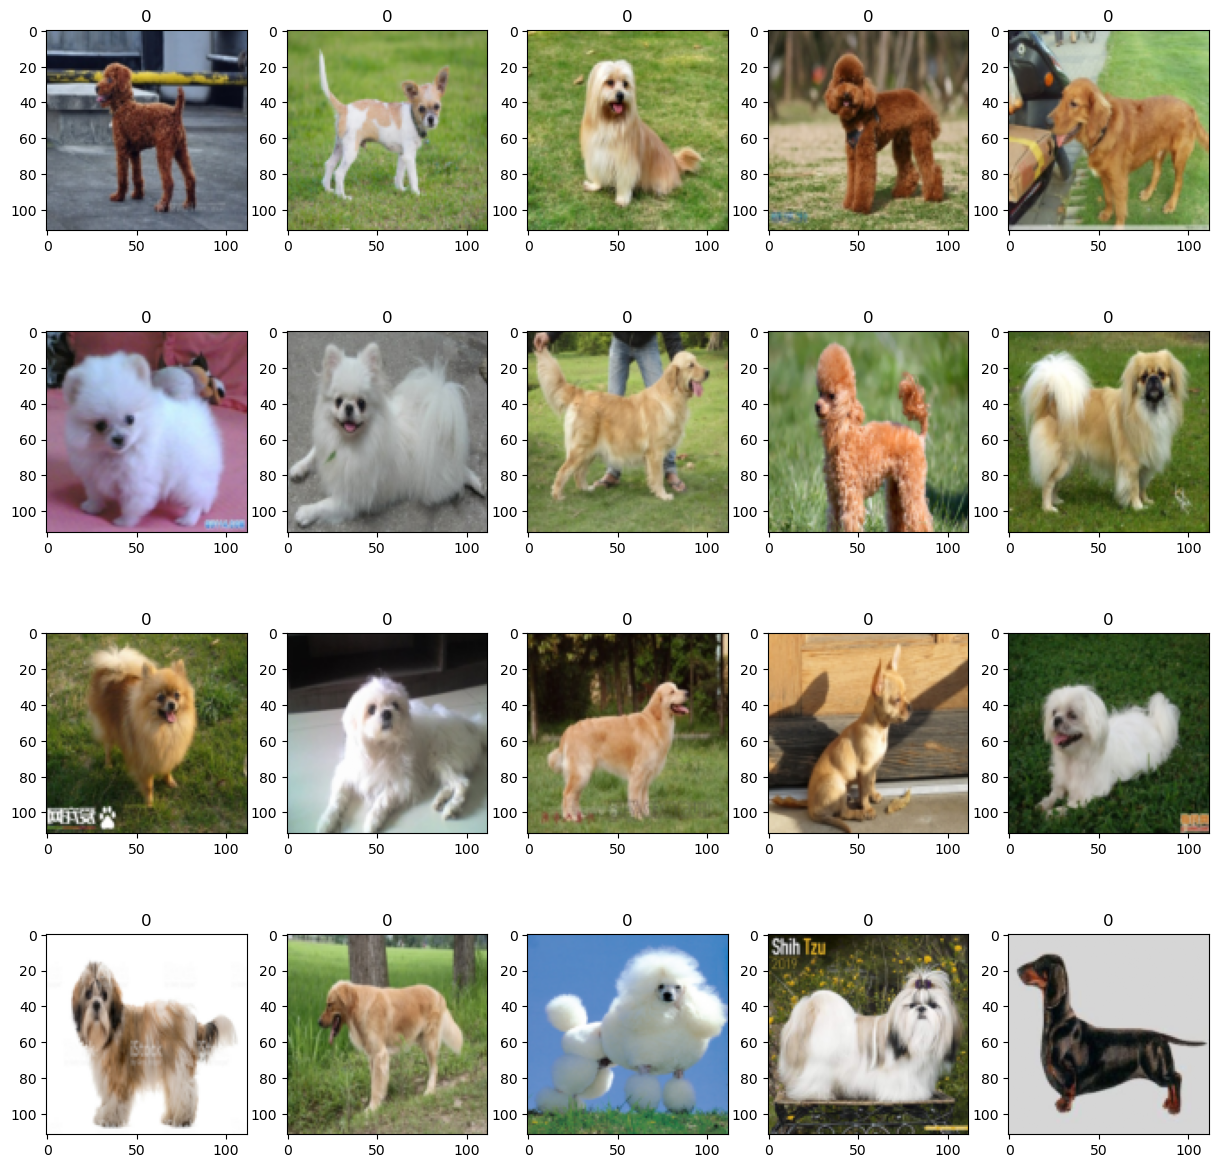

In [5]:
plt.figure(figsize=(15, 15))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(total_dataset[i][0].permute(1, 2, 0))
    plt.title(total_dataset[i][1])

In [6]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num+1, valid_num, test_num])

In [7]:
# 데이터 불균형 없이 잘 나눠졌는지 확인
# 정상 데이터가 더 많다 -> random하게 나누지 않으면 특정 데이터셋에 특정 클래스가 몰릴 수 있다.

cnt = 0

for i in range(len(train_dataset)):
    if train_dataset[i][1] == 1:
        cnt += 1

print(cnt/train_num)

cnt = 0

for i in range(len(valid_dataset)):
    if valid_dataset[i][1] == 1:
        cnt += 1

print(cnt/valid_num)

cnt = 0

for i in range(len(test_dataset)):
    if test_dataset[i][1] == 1:
        cnt += 1

print(cnt/test_num)

0.17317845828933473
0.17796610169491525
0.2542372881355932


In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# train, eval

In [9]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images) # 모델의 결과 -> 각 클래스의 확률으로 나온다.
        probs = torch.nn.functional.softmax(outputs, dim=1) # softmax를 사용해서 전체값을 확률으로 변환한다.
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, preds = torch.max(probs, 1)
        train_accuracy += (preds==labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, preds = torch.max(probs, 1)
            valid_accuracy += (preds==labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

# model

In [10]:
model = timm.create_model(
    'resnet34',
    pretrained=False,
    num_classes=2
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [11]:
for params in model.parameters():
    params.require_grads = False

for params in model.layer4[2].parameters():
    params.require_grads = True

for params in model.fc.parameters():
    params.require_grads = True

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.4874880979458491, Train Accuracy: 0.8069620253164557, Valid Loss: 0.5396795198321342, Valid Accuracy: 0.8220338983050848


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.4548359543085098, Train Accuracy: 0.8270042194092827, Valid Loss: 0.4603472352027893, Valid Accuracy: 0.8220338983050848


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.45057006826003393, Train Accuracy: 0.8248945147679325, Valid Loss: 0.45425596088171005, Valid Accuracy: 0.8220338983050848


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.4364065965016683, Train Accuracy: 0.8217299578059072, Valid Loss: 0.4720751643180847, Valid Accuracy: 0.8220338983050848


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.428788294394811, Train Accuracy: 0.8280590717299579, Valid Loss: 0.4528690278530121, Valid Accuracy: 0.8220338983050848


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.4112336168686549, Train Accuracy: 0.8238396624472574, Valid Loss: 0.48585551232099533, Valid Accuracy: 0.8220338983050848


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3768889163931211, Train Accuracy: 0.8459915611814346, Valid Loss: 0.7177407443523407, Valid Accuracy: 0.8135593220338984


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.36870105713605883, Train Accuracy: 0.8438818565400844, Valid Loss: 0.5760726928710938, Valid Accuracy: 0.6949152542372882


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3433982148766518, Train Accuracy: 0.859704641350211, Valid Loss: 0.4435746669769287, Valid Accuracy: 0.8305084745762712


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.29502316961685815, Train Accuracy: 0.8871308016877637, Valid Loss: 0.478707879781723, Valid Accuracy: 0.8135593220338984
